In [1]:
from __future__ import print_function

import math
import numpy as np
import pandas as pd
import scanpy as sc

from scipy.stats.stats import pearsonr
from sklearn.decomposition import PCA, FastICA, NMF


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

Import jupyterthemes for custom plot themes (optional)

In [86]:

from jupyterthemes import jtplot
#jtplot.style("chesterish")
jtplot.style("grade3")

plt.rcParams["figure.figsize"] = (10,10)

In [91]:
def rotate_point(origin, point, angle):
    """
        Rotate a point counterclockwise by a given angle around a given origin.
        The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point
    cos = math.cos(angle)
    sin = math.sin(angle)
    x_dif = (px - ox)
    y_dif = (py - oy)
    
    qx = ox + cos * x_dif - sin * y_dif
    qy = oy + sin * x_dif + cos * y_dif

    return qx, qy

def generate_linear_cloud(nb_points, sigma):
    """
        Generate a cloud of point following the y=x equation with
        a certain value of noise (standard deviation sigma) for y.
        Points are generated following the Normal distribution.
    """
    x = np.random.randn(1, nb_points)
    noise = np.random.normal(0, sigma, x.shape)
    y = x + noise
    return x, y

def rotate_array(x_ar, y_ar, origin, angle):
    """
        Rotate a 2D array around an origin point counter clockwise
        by a certain angle in degree.
    """

    x_rot = []
    y_rot = []

    for x, y in zip(x_ar, y_ar):
        x_tmp, y_tmp = rotate_point(origin, (x,y), math.radians(angle))
        x_rot.append(x_tmp)
        y_rot.append(y_tmp)

    return x_rot, y_rot

def plot_samples_centered(S, labels, center, axis_list=None):
    """
        Plot decomposition results. If axis_list is given, vectors of decomposition components
        will be plotted.
        Center can be given to use as the origin of vectors.
    """
    plt.scatter(S[:, 0], S[:, 1], s=2, marker='o', zorder=10,
                c=labels, alpha=0.5)
    if axis_list is not None:
        colors = ['orange', 'red', 'darkred']
        for color, axis in zip(colors, axis_list):
            axis /= axis.std()
            x_axis, y_axis = axis
            # Special case of zero origin vectors for NMF
            if color == 'darkred':
                # Trick to get legend to work
                plt.plot(0*x_axis , 0*y_axis, linewidth=1, color=color)
                plt.quiver(0, 0, x_axis, y_axis, zorder=11,
                           width=0.01, scale=4, color=color)
            else:
                # Trick to get legend to work
                plt.plot(0*x_axis+center , 0*y_axis+center, linewidth=1, color=color)
                plt.quiver(center[0], center[1], x_axis, y_axis, zorder=11,
                           width=0.01, scale=6, color=color)
            
    return

def Deconvolution_example(point_nb, sigma, angle,
                          ica_algo, ica_tol, ica_non_linearity,
                          nmf_init, nmf_solver, seed):
    """
    Interactive example comparing the deconvolution capacity of 3 methods: PCA, ICA and NMF.
    The idea is to compare how each method can disentangle two intersecting
    Gaussian distributions with coinciding means and whose principal axes form a sharp angle.
    
    Keyword arguments:
    point_nb -- number of points to generate for the cloud.
    sigma -- standard deviation of the distribution of points.
    angle -- angle forming between the 2 cloud points.
    ica_algo -- algorithm used for the ICA decomposition.
        Can be "parallel" or "deflation".
    ica_tol -- tolerance on update of each iteration.
    ica_non_linearity -- functional form of the G function used to approximate the
        neg-entropy. Can be "logcosh", "exp" or "cube".
    nmf_init -- method to initialise the nmf procedure.
        Can be "random" (non-negative random matrices,
        scaled with sqrt(X.mean() / n_components)),
        "nndsvd" (Nonnegative Double Singular Value Decomposition),
        "nndsvda" (NNDSVD with zeros filled with the average of X),
        "nndsvdar" (NNDSVD with zeros filled with small random values).
    nmf_solver -- numerical solver to use in nmf.
        Can be "cd" (Coordinate Descent) or "mu" (Multiplicative Update).
    seed -- fixed seed to random initialisation of points.
        Can be set to zero for true random.
    """
    
    ### Generate 2 clusters
    if int(seed)!=0:
        np.random.seed(int(seed))
    point_nb = int(point_nb)
    sigma = float(sigma)
    x1, y1 = generate_linear_cloud(point_nb, sigma)
    x2, y2 = generate_linear_cloud(point_nb, sigma)

    ### Rotate one cluster by a certain angle in degree arround an origin point
    origin = (0,0)
    angle = float(angle)
    x_new, y_new = rotate_array(x2, y2, origin, angle)

    # Find minimum value to translate the points clouds to be positive for NMF
    min_val = np.min(x1)
    if np.min(y1) < min_val:
        min_val = np.min(y1)
    if np.min(x_new) < min_val:
        min_val = np.min(x_new)
    if np.min(y_new) < min_val:
        min_val = np.min(y_new)
    abs_min = abs(min_val)
    
    ### Merge clusters into a matrix
    clust_1 = np.vstack((x1, y1)).T
    clust_2 = np.vstack((x_new, y_new)).T
    X = np.concatenate((clust_1, clust_2)) + abs_min
    #X = np.absolute(X)
    labels_clust = np.concatenate((np.repeat("C0",point_nb), np.repeat("C1",point_nb)))
    
    ### Perform PCA, ICA, NMF
    pca = PCA()
    S_pca = pca.fit_transform(X) # Fit PCA

    ica = FastICA(max_iter=10000, tol=float(ica_tol), whiten=True,
                  algorithm=ica_algo, fun=ica_non_linearity)
    S_ica = ica.fit(X).transform(X)  # Fit ICA
    #S_ica = ica.fit_transform(X)
    S_ica /= S_ica.std() # Normalise vectors

    nmf = NMF(max_iter=10000, init=nmf_init, solver=nmf_solver)
    S_nmf = nmf.fit(X).transform(X) # Fit NMF
    #S_nmf = nmf.fit_transform(X)
    S_nmf /= S_nmf.std() # Normalise vectors
    
    ### Plot decomposition results
    plt.figure()

    plt.subplot(2, 2, 1)
    axis_list = [pca.components_, ica.mixing_, nmf.components_]
    plot_samples_centered(X / np.std(X), labels_clust, (abs_min, abs_min), axis_list=axis_list)
    legend = plt.legend(['PCA', 'ICA', 'NMF'], loc='upper right', prop=dict(weight='bold',size=12))
    legend.set_zorder(100)
    plt.title('Observations', fontsize=24, fontweight='bold')

    plt.subplot(2, 2, 2)
    plot_samples_centered(S_pca / np.std(S_pca, axis=0), labels_clust, (abs_min, abs_min))
    plt.title('PCA recovered signals', fontsize=24, fontweight='bold')

    plt.subplot(2, 2, 3)
    plot_samples_centered(S_ica / np.std(S_ica), labels_clust, (abs_min, abs_min))
    plt.title('ICA recovered signals', fontsize=24, fontweight='bold')

    plt.subplot(2, 2, 4)
    plot_samples_centered(S_nmf / np.std(S_nmf), labels_clust, (abs_min, abs_min))
    plt.title('NMF recovered signals', fontsize=24, fontweight='bold')

    #plt.savefig("Artificial_example.png", format='png', dpi=300, quality=95)
    plt.show()
    
    return

Interactive example comparing the deconvolution capacity of 3 methods: PCA, ICA and NMF.
The idea is to compare how each method can disentangle two intersecting Gaussian distributions with coinciding means and whose principal axes form a sharp angle.
Many parametters can be modified:
- point_nb: number of points to generate for the cloud
- sigma: standard deviation of the distribution of points
- angle: angle forming between the 2 cloud points
- ica_algo: algorithm used for the ICA decomposition. Can be "parallel" or "deflation".
- ica_tol: tolerance on update of each iteration
- ica_non_linearity: functional form of the G function used to approximate the neg-entropy. Can be "logcosh", "exp" or "cube".
- nmf_init: method to initialise the nmf procedure. Can be "random" (non-negative random matrices, scaled with sqrt(X.mean() / n_components)), "nndsvd" (Nonnegative Double Singular Value Decomposition), "nndsvda" (NNDSVD with zeros filled with the average of X), "nndsvdar" (NNDSVD with zeros filled with small random values)
- nmf_solver: numerical solver to use in nmf. Can be "cd" (Coordinate Descent) or "mu" (Multiplicative Update)
- seed: fixed seed to random initialisation of points. Can be set to zero for true random.

In [92]:
interact_manual(Deconvolution_example,
                point_nb='10000', sigma='0.20', angle='40.0',
                ica_algo=['parallel','deflation'], ica_tol='1e-03',
                ica_non_linearity=['logcosh','exp','cube'],
                nmf_init=['random','nndsvd','nndsvda','nndsvdar'], nmf_solver=['cd','mu'],
                seed='300');

interactive(children=(Text(value='10000', description='point_nb'), Text(value='0.20', description='sigma'), Te…

Load data:
- Weighted list of genes relate to Proliferation and Immune response (Biton et al. Cell Rep. 2014)
- ICA decompositions in 100 components of BRCA bulk expression profiles (TCGA and METABRIC)
The "cache" option creates a cache file for faster future access.

In [47]:
Biton_cellcycle_metagene = sc.read("example_data/Biton_CellCycle_metagene.txt", cache = True,
                                   first_column_names = True, delimiter = "\t")
Biton_immun_metagene = sc.read("example_data/Biton_Immune_metagene.txt", cache = True,
                            first_column_names = True, delimiter = "\t")
ICA_BRCA_TCGA = sc.read("example_data/BRCA_TCGA_100_S.tsv",
                    cache = True, first_column_names = True, delimiter = "\t")
ICA_BRCA_METABRIC = sc.read("example_data/BRCA_METABRIC_100_S.tsv",
                    cache = True, first_column_names = True, delimiter = "\t")

In [48]:
def Find_common_genes_index(data_1, data_2):
    """
    Find common genes between two scanpy datasets and returns their corresponding
    indexes sorted in the same order of genes.
    """
    
    common_genes = np.sort(list(set(data_1.obs_names) & set(data_2.obs_names)))
    N_1 = [i for i in range(len(data_1.obs_names)) if data_1.obs_names[i] in common_genes]
    N_2 = [i for i in range(len(data_2.obs_names)) if data_2.obs_names[i] in common_genes]
    # Find index of data_2 genes common with data_1 sorted in the same order
    N_1 = [N_1[i] for i in np.argsort(data_1.obs_names[N_1])]
    N_2 = [N_2[i] for i in np.argsort(data_2.obs_names[N_2])]

    return N_1, N_2

def Plot_metagene_correlation(metagene_data, metagene_ind, ica_data, ica_ind,
                            metagene_type, data_type):
    """
    Create a scatter polar figure of correlations between ICs and a metagene.
    By default, the absolute correlation will be displayed
    """

    corr_list = []
    for comp in range(len(ica_data.var_names)):
        
        cor = pearsonr(metagene_data[metagene_ind].X,
                       ica_data.transpose()[comp].X[ica_ind])
        corr_list.append(abs(cor[0]))
            
    df = pd.DataFrame(dict(
        correlation=corr_list,
        comp_names=ica_data.var_names,
        size=[1]*len(corr_list)))

    fig = go.Scatterpolar(name=metagene_type+" "+data_type,
                          r=corr_list, theta=ica_data.var_names,
                          mode='markers',
                          marker=dict(size=12,
                                      color=corr_list,
                                      cmin=0, cmax=0.7,
                                      colorscale="Reds",
                                      colorbar=dict(x=1.02))
                         )
    return fig

Retrieve index of common genes between datasets and metagenes

In [49]:
tcga_cellcycle_metagene_common_ind, tcga_cycle_ica_common_ind = Find_common_genes_index(Biton_cellcycle_metagene, ICA_BRCA_TCGA)
tcga_immune_metagene_common_ind, tcga_immune_ica_common_ind = Find_common_genes_index(Biton_immun_metagene, ICA_BRCA_TCGA)
meta_cellcycle_metagene_common_ind, meta_cycle_ica_common_ind = Find_common_genes_index(Biton_cellcycle_metagene, ICA_BRCA_METABRIC)
meta_immune_metagene_common_ind, meta_immune_ica_common_ind = Find_common_genes_index(Biton_immun_metagene, ICA_BRCA_METABRIC)

Plot correlations between Independent Components (IC) and Biton metagenes as Polar plots

In [93]:
figure = go.Figure()
figure = make_subplots(rows=2, cols=2, specs=[[{'type': 'polar'}]*2]*2,
                      subplot_titles=("Immune TCGA", "Cell Cycle TCGA",
                                      "Immune METABRIC", "Cell Cycle METABRIC"))

figure.add_trace(Plot_metagene_correlation(Biton_immun_metagene, tcga_immune_metagene_common_ind,
                          ICA_BRCA_TCGA, tcga_immune_ica_common_ind,
                         "Immune", "TCGA"), 1, 1)
figure.add_trace(Plot_metagene_correlation(Biton_cellcycle_metagene, tcga_cellcycle_metagene_common_ind,
                          ICA_BRCA_TCGA, tcga_cycle_ica_common_ind,
                         "Cell Cycle", "TCGA"), 1, 2)
figure.add_trace(Plot_metagene_correlation(Biton_immun_metagene, meta_immune_metagene_common_ind,
                          ICA_BRCA_METABRIC, meta_immune_ica_common_ind,
                         "Immune", "METABRIC"), 2, 1)
figure.add_trace(Plot_metagene_correlation(Biton_cellcycle_metagene, meta_cellcycle_metagene_common_ind,
                          ICA_BRCA_METABRIC, meta_cycle_ica_common_ind,
                         "Cell Cycle", "METABRIC"), 2, 2)
figure.update_traces(mode="markers")
figure.update_layout(
    polar=dict(angularaxis=dict(showticklabels=False),
              radialaxis=dict(tickangle=90)),
    polar2=dict(angularaxis=dict(showticklabels=False),
              radialaxis=dict(tickangle=90)),
    polar3=dict(angularaxis=dict(showticklabels=False),
              radialaxis=dict(tickangle=90)),
    polar4=dict(angularaxis=dict(showticklabels=False),
              radialaxis=dict(tickangle=90)),
    width=900, height=900,
    showlegend=False,
    title = dict(text='Correlation of Biton Metagenes with ICA components', x=0.5),
    title_font_size=30
    )
for f in figure['layout']['annotations']:
    f['font'] = dict(size=24)
figure.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning:

In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.



Compute the correlation matrix between ICs from TCGA and METABRIC decompositions

In [10]:
tcga_common_ind, metabric_common_ind = Find_common_genes_index(ICA_BRCA_TCGA, ICA_BRCA_METABRIC)

corr_matrix = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        cor = pearsonr(ICA_BRCA_TCGA.transpose()[i].X[tcga_common_ind],
                           ICA_BRCA_METABRIC.transpose()[j].X[metabric_common_ind])
        corr_matrix[i][j] = abs(cor[0])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning:

In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.



Plot the correlation matrix

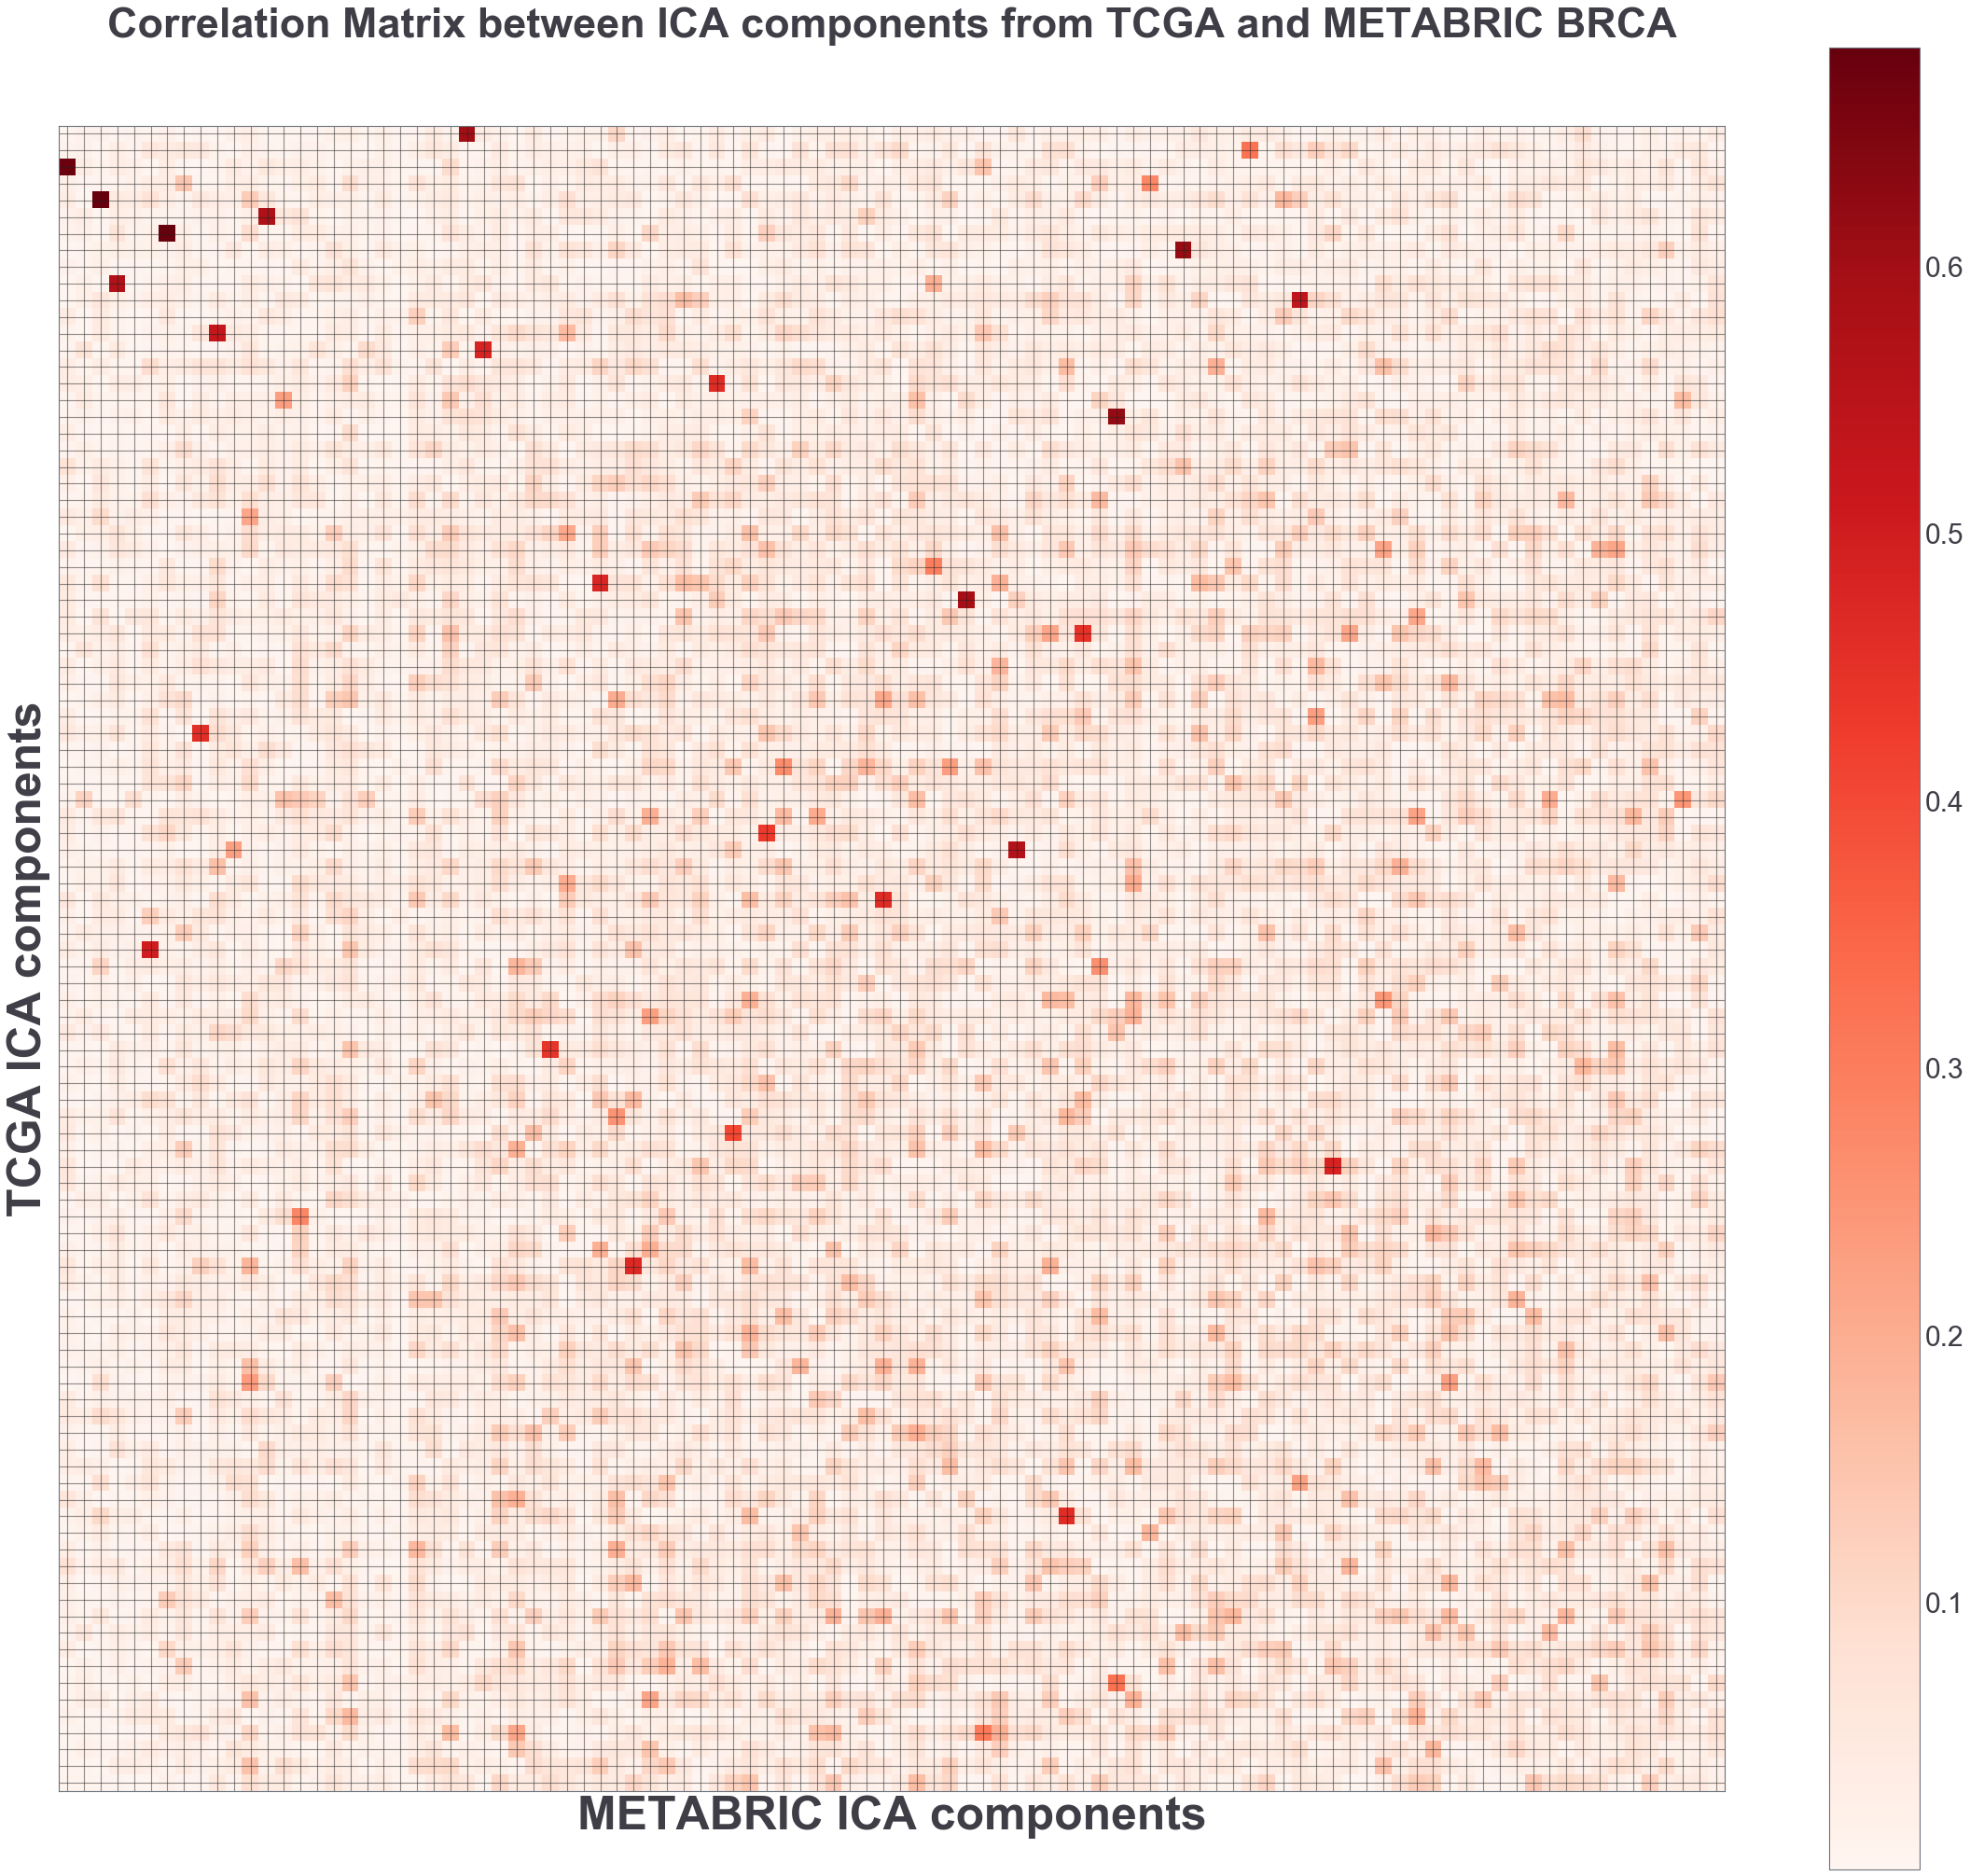

In [95]:
df_corr = pd.DataFrame(corr_matrix)

f = plt.figure(figsize=(40, 35))
plt.matshow(df_corr, fignum=f.number, cmap='Reds')
plt.xticks(range(df_corr.shape[1]), [])
plt.yticks(range(df_corr.shape[1]), [])
plt.grid(color='k', alpha=0.5)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=30)
plt.xlabel('METABRIC ICA components', fontsize=50, fontweight="bold")
plt.ylabel('TCGA ICA components', fontsize=50, fontweight="bold")
plt.title('Correlation Matrix between ICA components from TCGA and METABRIC BRCA',
          fontsize=45, fontweight="bold");
#plt.savefig("Correlation_matrix.png", format='png', dpi=300, quality=95)
plt.show()